### Feature selecture using target permutation

The notebook uses a procedure described in [this article]( https://academic.oup.com/bioinformatics/article/26/10/1340/193348).

Feature selection process using target permutation tests actual importance significance against the distribution of feature importances when fitted to noise (shuffled target).

The notebook implements the following steps  :
 - Create the null importances distributions : these are created fitting the model over several runs on a shuffled version of the target. This shows how the model can make sense of a feature irrespective of the target.
 - Fit the model on the original target and gather the feature importances. This gives us a benchmark whose significance can be tested against the Null Importances Distribution
 - for each feature test the actual importance:
    - Compute the probabability of the actual importance wrt the null distribution. I will use a very simple estimation using occurences while the article proposes to fit known distribution to the gathered data. In fact here I'll compute 1 - the proba so that things are in the right order.
    - Simply compare the actual importance to the mean and max of the null importances. This will give sort of a feature importance that allows to see major features in the dataset. Indeed the previous method may give us lots of ones.

For processing time reasons, the notebook will only cover application_train.csv but you can extend it as you wish.


### Import a few packages

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import time
from lightgbm import LGBMClassifier
import lightgbm as lgb

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter('ignore', UserWarning)
warnings.filterwarnings('ignore')

import gc
gc.enable()

### Read application_train

Read data and take care of categorical features

In [31]:
data = pd.read_csv('application_train.csv')

categorical_feats = [
    f for f in data.columns if data[f].dtype == 'object'
]

categorical_feats
for f_ in categorical_feats:#将字符串特征的类别转换为ctaegory(数字)特征类别
    data[f_], _ = pd.factorize(data[f_])
    # Set feature type as categorical
    data[f_] = data[f_].astype('category')
#     print(data[f_])
categorical_feats

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

### Create a scoring function

Coring function uses LightGBM in RandomForest mode fitted on the full dataset 

In [3]:
def get_feature_importances(data, shuffle, seed=None):#训练lgb模型，创建特征重要性输出到imp_df
    # Gather real features
    train_features = [f for f in data if f not in ['TARGET', 'SK_ID_CURR']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['TARGET'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['TARGET'].copy().sample(frac=1.0)#指定随机抽取行的比例
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'rf',
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'num_leaves': 127,
        'max_depth': 8,
        'seed': seed,
        'bagging_freq': 1,
        'n_jobs': 4,
        'verbose':-1
    }
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200, categorical_feature=categorical_feats)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    
    return imp_df

### Build the benchmark for feature importance

![](http://)The original paper does not talk about this but I think it makes sense to have a distribution of actual importances as well

In [4]:
# Seed the unexpected randomness of this world
np.random.seed(123)
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=data, shuffle=False)

In [5]:
actual_imp_df.head(n=2)#返回对象的前n行

,feature,importance_gain,importance_split,trn_score
0,NAME_CONTRACT_TYPE,4855.592482,137,0.757312
1,CODE_GENDER,24112.439761,534,0.757312


In [6]:
print(actual_imp_df.shape[0])#特征数120

120


### Build Null Importances distribution

In [7]:
null_imp_df = pd.DataFrame()#存贮null_importances特征
nb_runs = 10
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=data, shuffle=True)
    imp_df['run'] = i + 1 
    print('null_imp_df000',null_imp_df)
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)#纵向拼接,将每一轮计算到的imp_df中的数据拼到到null_imp_df末尾
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)
    print(null_imp_df.shape[0])

null_imp_df000 Empty DataFrame
Columns: []
Index: []
Done with    1 of   10 (Spent   0.3 min)120
null_imp_df000                         feature  importance_gain  importance_split  trn_score  \
0            NAME_CONTRACT_TYPE       209.131441                22   0.711386   
1                   CODE_GENDER       401.928401                77   0.711386   
2                  FLAG_OWN_CAR       219.943234                37   0.711386   
3               FLAG_OWN_REALTY       520.170158                74   0.711386   
4                  CNT_CHILDREN       560.785895                66   0.711386   
..                          ...              ...               ...        ...   
115   AMT_REQ_CREDIT_BUREAU_DAY       113.145650                12   0.711386   
116  AMT_REQ_CREDIT_BUREAU_WEEK       401.180971                42   0.711386   
117   AMT_REQ_CREDIT_BUREAU_MON      1641.631020               157   0.711386   
118   AMT_REQ_CREDIT_BUREAU_QRT      1092.333279               109   0.711386 

Done with    8 of   10 (Spent   2.1 min)960
null_imp_df000                         feature  importance_gain  importance_split  trn_score  \
0            NAME_CONTRACT_TYPE       209.131441                22   0.711386   
1                   CODE_GENDER       401.928401                77   0.711386   
2                  FLAG_OWN_CAR       219.943234                37   0.711386   
3               FLAG_OWN_REALTY       520.170158                74   0.711386   
4                  CNT_CHILDREN       560.785895                66   0.711386   
..                          ...              ...               ...        ...   
115   AMT_REQ_CREDIT_BUREAU_DAY        82.652309                10   0.717841   
116  AMT_REQ_CREDIT_BUREAU_WEEK       367.226377                34   0.717841   
117   AMT_REQ_CREDIT_BUREAU_MON      1246.967101               129   0.717841   
118   AMT_REQ_CREDIT_BUREAU_QRT      1119.675489               105   0.717841   
119  AMT_REQ_CREDIT_BUREAU_YEAR      3631.647042  

In [8]:
null_imp_df.head()

,feature,importance_gain,importance_split,trn_score,run
0,NAME_CONTRACT_TYPE,209.131441,22,0.711386,1
1,CODE_GENDER,401.928401,77,0.711386,1
2,FLAG_OWN_CAR,219.943234,37,0.711386,1
3,FLAG_OWN_REALTY,520.170158,74,0.711386,1
4,CNT_CHILDREN,560.785895,66,0.711386,1


In [9]:
null_imp_df

,feature,importance_gain,importance_split,trn_score,run
0,NAME_CONTRACT_TYPE,209.131441,22,0.711386,1
1,CODE_GENDER,401.928401,77,0.711386,1
2,FLAG_OWN_CAR,219.943234,37,0.711386,1
3,FLAG_OWN_REALTY,520.170158,74,0.711386,1
4,CNT_CHILDREN,560.785895,66,0.711386,1
...,...,...,...,...,...
115,AMT_REQ_CREDIT_BUREAU_DAY,106.177921,12,0.692508,10
116,AMT_REQ_CREDIT_BUREAU_WEEK,225.389927,21,0.692508,10
117,AMT_REQ_CREDIT_BUREAU_MON,1268.885670,126,0.692508,10
118,AMT_REQ_CREDIT_BUREAU_QRT,1152.108844,121,0.692508,10


### Display distribution examples

A few plots are better than any words

In [10]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances,画split重要性图,横坐标：actual_imp_df_，null_imp_df_的分裂次数（增益值），纵坐标：该数值在各轮训练中出现的次数
    ax = plt.subplot(gs[0, 0])
    #画出每一轮训练得到的
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')#
    
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), #.mean（）似乎没用
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')#只表示Real Target横坐标位置，纵坐标和Null importances的纵坐标最大值保持一致
    
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), #
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())
        

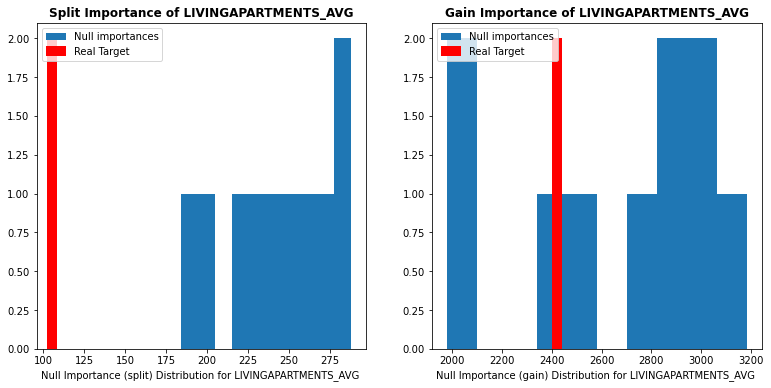

In [11]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='LIVINGAPARTMENTS_AVG')

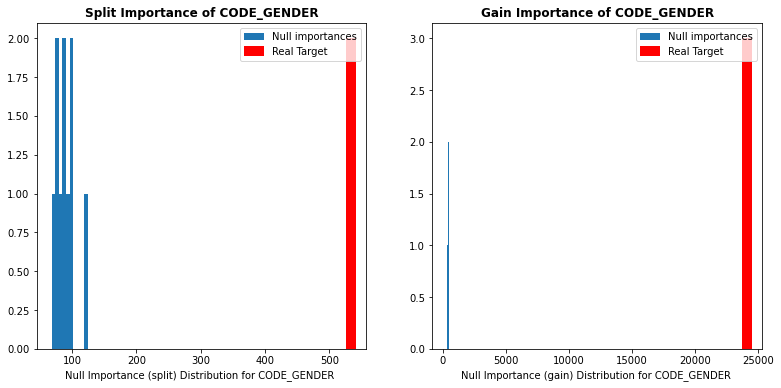

In [12]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='CODE_GENDER')

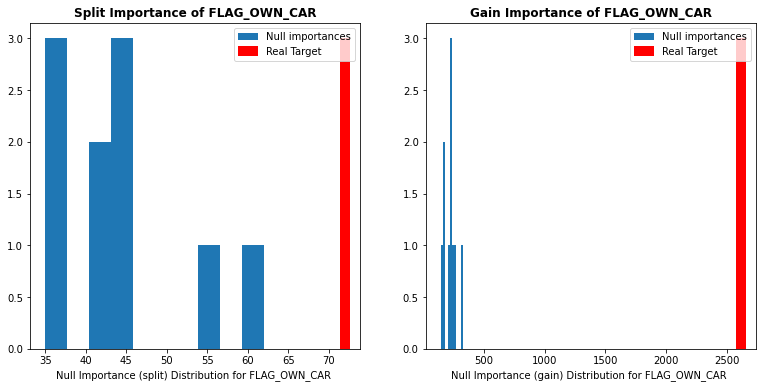

In [13]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='FLAG_OWN_CAR')

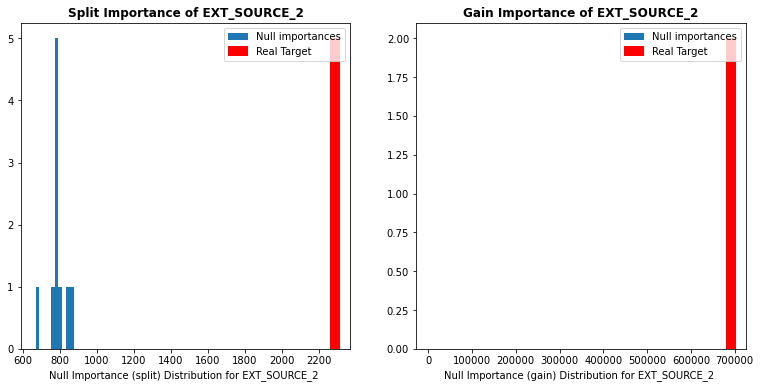

In [14]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='EXT_SOURCE_2')

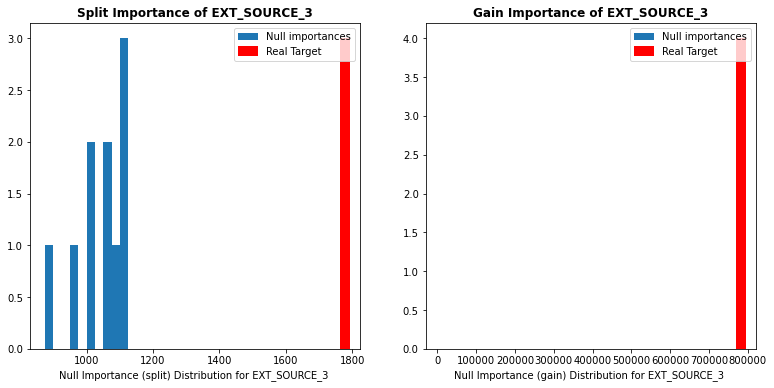

In [15]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='EXT_SOURCE_3')

From the above plot I believe the power of the exposed feature selection method is demonstrated. In particular it is well known that :
 - Any feature sufficient variance can be used and made sense of by tree models. You can always find splits that help scoring better
 - Correlated features have decaying importances once one of them is used by the model. The chosen feature will have strong importance and its correlated suite will have decaying importances
 
 The current method allows to :
  - Drop high variance features if they are not really related to the target
  - Remove the decaying factor on correlated features, showing their real importance (or unbiased importance)


### Score features

There are several ways to score features : 
 - Compute the number of samples in the actual importances that are away from the null importances recorded distribution.
 - Compute ratios like Actual / Null Max, Actual  / Null Mean,  Actual Mean / Null Max
 
In a first step I will use the log actual feature importance divided by the 75 percentile of null distribution.

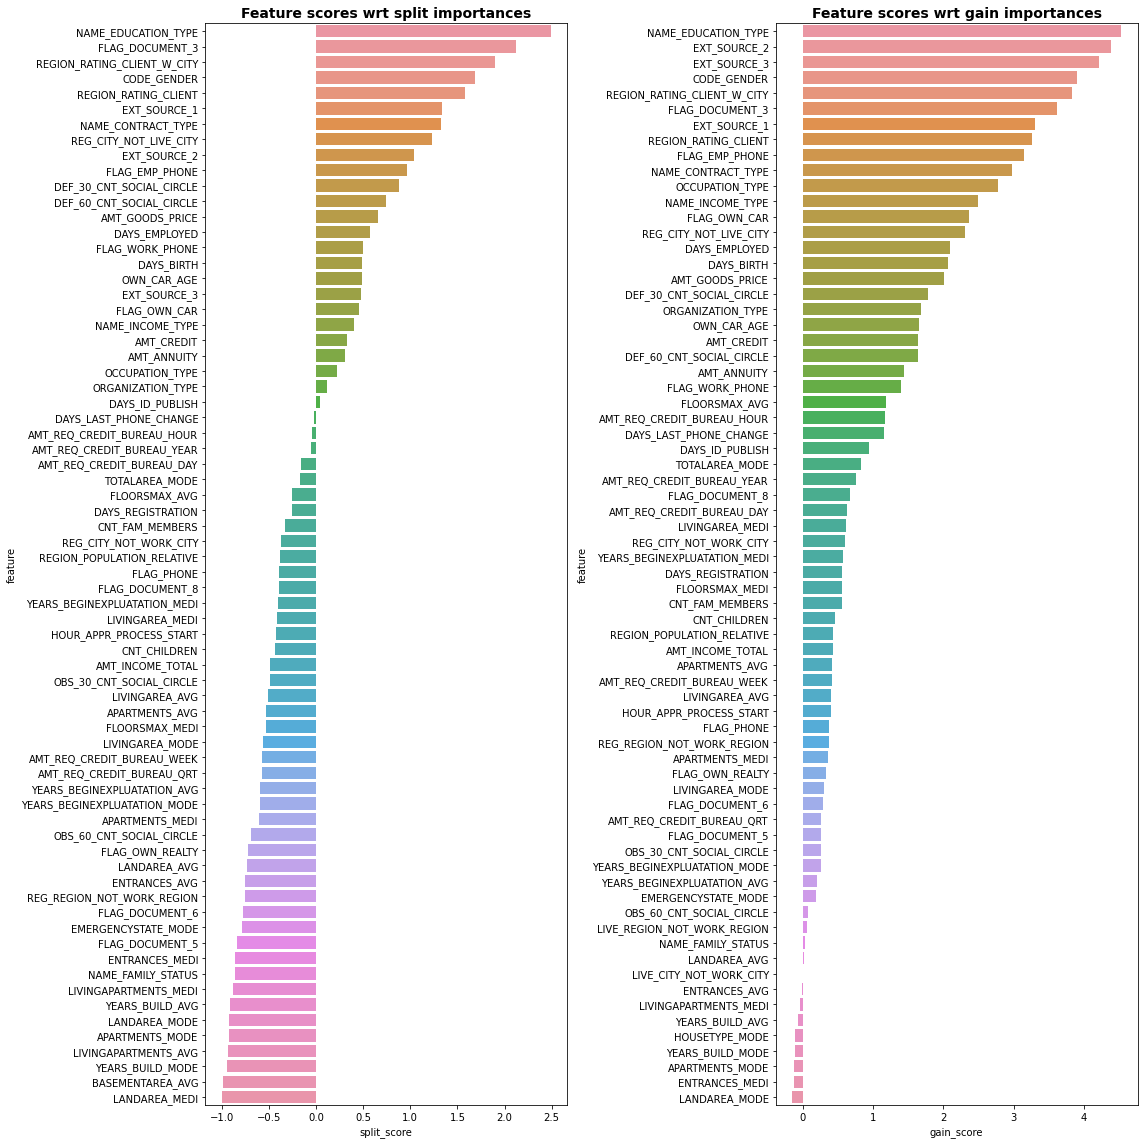

In [16]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():#循环特征
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
#     print(f_null_imps_gain)
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero,np.percentile:找到一组数的分位数值
#     print(gain_score)
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

### Save data

In [17]:
null_imp_df.to_csv('null_importances_distribution_rf.csv')
actual_imp_df.to_csv('actual_importances_ditribution_rf.csv')

### Check the impact of removing uncorrelated features

Here I'll use a different metric to asses correlation to the target

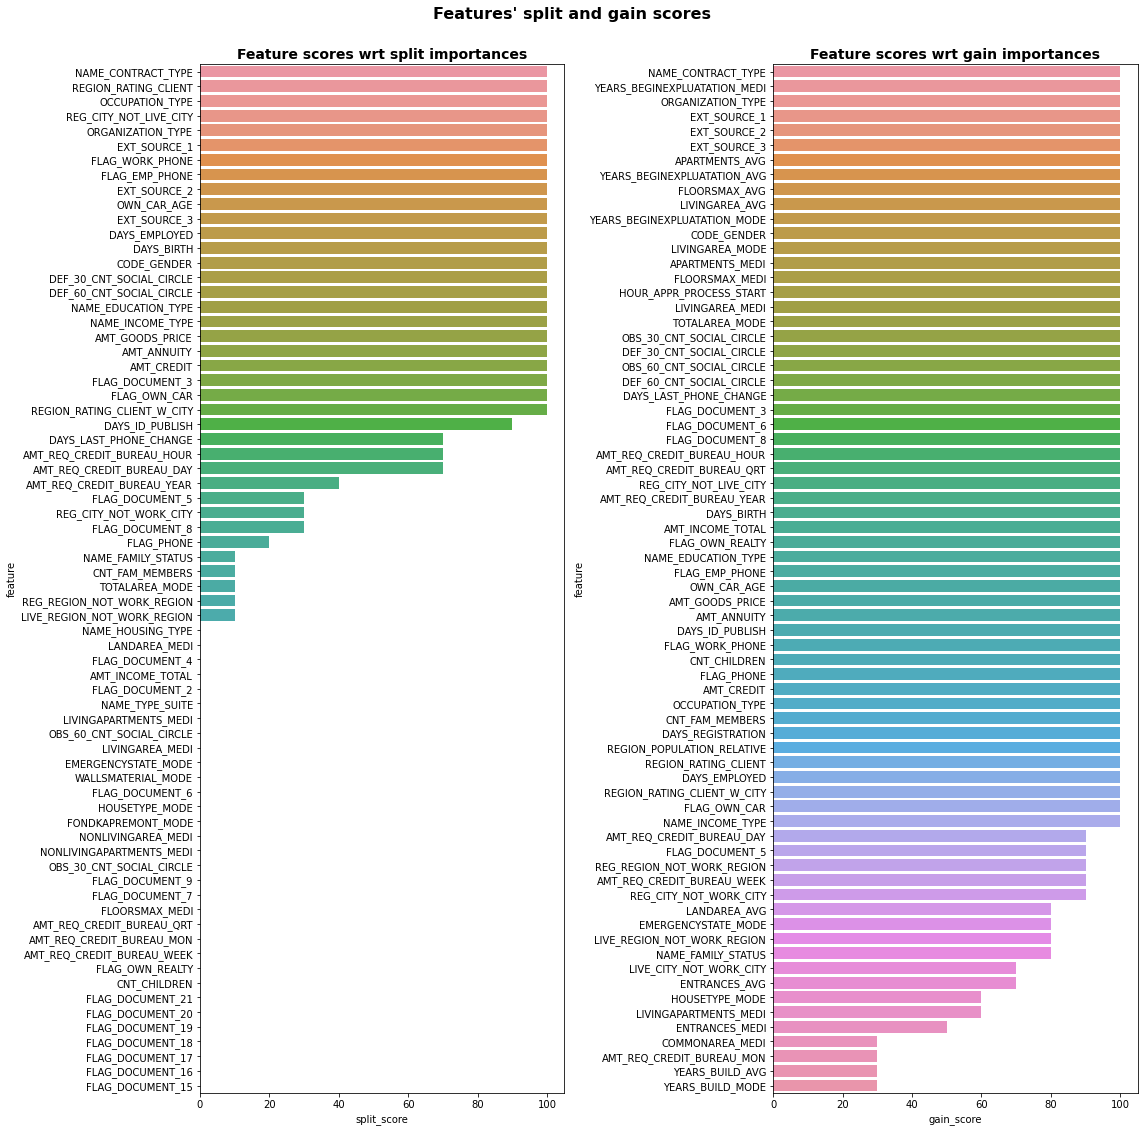

In [18]:
correlation_scores = []##'feature', 'split_score', 'gain_score'    分数应该是越大越有代表性
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size#计算公式，f_act_imps和np.percentile(f_act_imps, 25)基本一样
    
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size#计算公式
    
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

#画图部分
fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

### Score feature removal for different thresholds

In [34]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    # Fit LightGBM 
    dtrain = lgb.Dataset(df[train_features], target, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'learning_rate': .1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'num_leaves': 31,
        'max_depth': -1,
        'seed': 13,
        'n_jobs': 4,
        'min_split_gain': .00001,
        'reg_alpha': .00001,
        'reg_lambda': .00001,
        'metric': 'auc',
        'verbose':-1
    }
    
    # Fit the model
    hist = lgb.cv(
        params=lgb_params, 
        train_set=dtrain, 
        num_boost_round=2000,
        categorical_feature=cat_feats,
        nfold=5,
        stratified=True,
        shuffle=True,
        early_stopping_rounds=50,
        verbose_eval=0,
        seed=17
    )
    # Return the last mean / std values 
    return hist['auc-mean'][-1], hist['auc-stdv'][-1]#stdv-标准偏差

# features = [f for f in data.columns if f not in ['SK_ID_CURR', 'TARGET']]
# score_feature_selection(df=data[features], train_features=features, target=data['TARGET'])

for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]#选择大于阈值的特征
    split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=data, train_features=split_feats, cat_feats=split_cat_feats, target=data['TARGET'])
    print('split_feats',len(split_feats),'\n',split_feats,   '\n','split_cat_feats',len(split_cat_feats),'\n',split_cat_feats)
    print('\t SPLIT : %.6f +/- %.6f' % (split_results[0], split_results[1]))
    gain_results = score_feature_selection(df=data, train_features=gain_feats, cat_feats=gain_cat_feats, target=data['TARGET'])
    print('\t GAIN  : %.6f +/- %.6f' % (gain_results[0], gain_results[1]))



Results for threshold   0
split_feats 120 
 ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'C